## Table of Contents

- [1. Data Extraction](#etl)
- [2. Data Preprocessing](#dpp)
    - [2.1 Missing & Duplicate Data](#null)
    - [2.2 Analysis Calculation](#calc)
    - [2.3 Test vs. Training Set](#tt)
- [3. Exploratory Data Analysis](#eda)
    - [3.1 Metal Concentrations](#3_1)
    - [3.2 Feed Particle Size ](#3_2)
    - [3.3 Total Concentrations](#3_3)
- [4. Model Training](#train)
    - [4.1 Baseline sMAPE](#4_1)
    - [4.2 Logistic Regression](#4_2)
    - [4.3 Decision Tree Regressor](#4_3)
    - [4.4 Random Forest Regressor](#4_4)
- [5. Parameter Hypertuning](#pht)
    - [5.1 Rough Model](#5_1)
    - [5.2 Final Model](#5_2)
    - [5.3 Tuned Model](#5_3)
- [Conclusion](#end)

### 1. Data Extraction <a class="anchor" id="etl"></a>

In [32]:
# import libraries and data sources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display

try:
    df_full = pd.read_csv('../datasets/gold_recovery_full.csv')
    df_full.sample(5)
except:
    print("full data not found")




Dataframe containing all raw data of measurements throughout the gold extraction process- training and testing. 

In [33]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### 2. Data preprocessing <a class="anchor" id="dpp"></a>

#### 2.1 Missing & Duplicate Data <a class="anchor" id="null"></a>

Non-nulls aren't adding up; check what percentage are nulls to possibly drop.

In [34]:
# define function to display how much data is removed when dealing with nulls
def display_slice_percent(df,df_sliced):
    print("Number of rows dropping: {:}".format(df.shape[0]-df_sliced.shape[0]))
    print("Remaining percent of raw data: {:.2f}%".format(df_sliced.shape[0]/df.shape[0]*100))

df_full_na = df_full.dropna()
df_full_na = df_full_na.drop_duplicates()
display_slice_percent(df_full,df_full_na)

Number of rows dropping: 6622
Remaining percent of raw data: 70.85%


There are far too many null values to drop so I further investigate key columns and their nulls. These null values could have been an entry error of should have been zeroes, we must request clarification from data engineers. If there are missing or zero mineral values it would follow that related materials or measurements used further in the process will also be zero or misssing, as they aren't needed. Let's try removing only entries where the key measures (gold input/output) are null so that we don't distrupt the proper distribution in those key measures.

In [35]:
# create function for dealing with key nulls
def slice_out_null_cols(df,cols):
    df_na = df
    for col in cols:
        df_na = df_na.loc[(df_na[col].isna() == False)]
    return df_na

# key columns that we don't want to create anomalies:
key_cols_full = [
    'rougher.input.feed_ag','rougher.output.concentrate_ag','rougher.output.recovery','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag','final.output.recovery'
]
df_full_na = slice_out_null_cols(df_full,key_cols_full)
display_slice_percent(df_full,df_full_na)

Number of rows dropping: 3278
Remaining percent of raw data: 85.57%


Removing the nulls from the key columns has less impact on the data size. With the remaining nulls we have a few options: median, or back/front-fill. The fill method would make sense in this context because valid values from closely located rows have time-based relation. Processes done in the same hour range will have similar procedures & measures. I will also convert the date column to dateTime.

In [36]:
# define function for preparing dataframe, will be reused on test and training data also
def prep_df(df):
    try: 
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    except: 
        print('Date column not converted')

    df = df.fillna(method='ffill')
    df = df.drop_duplicates()
    print("Non-null rows: ",df.isna().shape[0])

    print("DataType of Date column: ",df['date'].dtypes)
    return df

df_full = prep_df(df_full_na)

Non-null rows:  19438
DataType of Date column:  datetime64[ns]


In [37]:
# check duplicates
display(df_full[df_full.duplicated() == True].count())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

No more null values and Date column has been converted. No duplicate entries found.

In [38]:
try:
    df_train = pd.read_csv('../datasets/gold_recovery_train.csv')
    display(df_train.sample(5))
except:
    print("Training data not found")

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
589,2016-02-08 13:00:00,5.464262,10.278162,NaN,44.524072,52.460835,10.518978,0.878393,16.085942,2.276740,...,17.034898,-499.536232,16.082915,-500.146682,17.992113,-499.631520,16.016369,-499.721140,18.040435,-500.074062
3905,2016-06-25 16:59:59,5.658572,9.254408,9.817427,43.619748,68.853908,8.847710,1.520557,11.708759,2.270660,...,15.997183,-500.009386,8.096627,-500.981018,16.036623,-498.543790,6.979556,-499.280877,25.071079,-499.786403
4889,2016-08-05 16:59:59,5.537095,8.302044,12.008434,46.442532,56.722067,9.716983,2.819179,2.306070,3.891503,...,19.939091,-399.665185,10.009571,-400.203788,8.910628,-399.583988,5.043795,-399.989982,22.975787,-500.129950
10510,2017-07-27 21:59:59,4.578405,7.650507,8.490526,48.586455,68.432627,6.539078,1.874868,10.743470,2.069705,...,16.985072,-499.734114,10.049965,-400.126399,15.998373,-500.011118,10.028907,-500.105264,15.018646,-500.171013
5112,2016-08-14 23:59:59,5.790125,9.118676,11.924855,44.631905,73.229844,11.083326,2.766401,10.843293,3.387383,...,18.003880,-399.667686,9.928566,-400.186557,14.998763,-412.692609,4.984798,-400.304878,23.018957,-498.530030


The training data begins on the same date/time as the full data so it will be the first indexes of full.

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Train has all the same columns as the full data. Will use same method to deal with nulls as full data.

In [40]:
# same method of filling nulls and converting date datatype
df_train_na = slice_out_null_cols(df_train,key_cols_full)
display_slice_percent(df_train,df_train_na)
df_train = prep_df(df_train_na)

Number of rows dropping: 2712
Remaining percent of raw data: 83.91%
Non-null rows:  14148
DataType of Date column:  datetime64[ns]


In [41]:
try:
    df_test = pd.read_csv('../datasets/gold_recovery_test.csv')
    display(df_test.sample(5))
except:
    print("Test data not found")

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2758,2016-12-24 22:59:59,170.881141,11.498403,6.93,1.461730,1696.500964,-499.882923,1698.121593,-500.168007,1699.342383,...,16.991701,-500.389318,14.943604,-500.375390,13.181722,-500.108159,12.027988,-499.561371,21.004286,-499.856784
3076,2017-09-07 04:59:59,NaN,NaN,6.44,NaN,0.000000,-797.032263,0.000000,-799.990817,0.000000,...,0.000000,-799.734670,0.000000,-799.864721,0.509332,-796.842969,0.654349,-800.041654,0.283762,-809.803660
2644,2016-12-20 04:59:59,218.300663,12.152857,7.25,1.149351,1500.432960,-499.586155,1502.812387,-501.197021,1501.353813,...,17.043033,-497.582503,15.002765,-446.985973,13.851577,-499.226268,11.997048,-499.766935,20.986761,-498.805469
5659,2017-12-23 19:59:59,220.690872,14.979684,8.31,1.300390,1599.004973,-400.651614,1599.414839,-399.703372,1384.050150,...,19.998883,-492.825727,15.084407,-499.087794,10.968858,-469.078997,9.096466,-484.927187,11.889360,-504.607525
5572,2017-12-20 04:59:59,248.026368,13.950483,8.51,1.478997,1552.114003,-500.300261,1551.318902,-477.834529,1416.206075,...,19.999322,-500.111969,15.078484,-499.142240,10.977804,-499.787345,9.037802,-499.813479,11.984838,-499.698265


Similar to full data, starting from later date.

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

The test data is missing some of the key columns we dealt with in the full data.

In [43]:
# same method but different key cols, filling remaining nulls and converting date datatype
key_cols_test = [
    'rougher.input.feed_ag','rougher.input.feed_ag'
]
df_test_na = slice_out_null_cols(df_test,key_cols_test)
display_slice_percent(df_test,df_test_na)
df_test = prep_df(df_test_na)

Number of rows dropping: 16
Remaining percent of raw data: 99.73%
Non-null rows:  5840
DataType of Date column:  datetime64[ns]


Few of the key columns in the test data had nulls because it was missing most of the columns from the full data. We now have training and test data for further analysis, prep, and modeling.

#### 2.2 Analysis Calculations <a class="anchor" id="calc"></a>

I will use my own calculations for `rougher.output.recovery` on the training data then check against the recorded values with MAE measure.

In [44]:
def recovery_calc(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    
    if (F*(C-T)) != 0 and 0 <= ((C*(F-T))/(F*(C-T)))*100 <= 100:
        return ((C*(F-T))/(F*(C-T)))*100
    else:
        return "NA"

df_train['recovery_calculated'] = df_train.apply(recovery_calc, axis=1)
print("calculated recovery values:")
display(df_train['recovery_calculated'].describe())
print("recorded recovery values:")
display(df_train['rougher.output.recovery'].describe())

calculated recovery values:


count    14148.000000
mean        82.704366
std         14.479659
min         -0.000000
25%         79.992503
50%         85.299535
75%         90.165026
max        100.000000
Name: recovery_calculated, dtype: float64

recorded recovery values:


count    14148.000000
mean        82.704366
std         14.479659
min          0.000000
25%         79.992503
50%         85.299535
75%         90.165026
max        100.000000
Name: rougher.output.recovery, dtype: float64

The calculated recovery looks virtually identical to the given recovery so let's check the MAE.

In [45]:
print("MAE: ",mean_absolute_error(df_train['rougher.output.recovery'], df_train['recovery_calculated']))

# drop calculated recovery
df_train = df_train.drop(['recovery_calculated'],axis=1)

MAE:  9.317712310260913e-15


The MAE is exponentially small, indicating high accuracy in the recovery calculation.

#### 2.3 Test vs. Training Set <a class="anchor" id="tt"></a>

Let's take a look at the differences between the features in the test and training sets.

In [46]:
missing_columns = set(list(df_train.columns))-set(list(df_test.columns))
display(missing_columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The test data set doesn't have any of the output measurements from the entire extraction process and calculating factors (ratios of sulfate to gold) from flotation. The two recovery columns that will be the targets for the model need to be added, otherwise there won't be any measure of the model. Now we know what features we can't use for training the models.

We will add from the full data, using the dates to match indeces, for the missing targets. 

In [47]:
# only take df_full values from dates of test data
df_test_dates = df_test['date']
df_full_test = df_full.query('date in @df_test_dates')
df_full_test = df_full_test.reset_index(drop=True)

# only using needed columns
df_full_test[['rougher.output.recovery','final.output.recovery']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  5290 non-null   float64
 1   final.output.recovery    5290 non-null   float64
dtypes: float64(2)
memory usage: 82.8 KB


In [48]:
df_test['rougher.output.recovery'] = df_full_test['rougher.output.recovery']
df_test['final.output.recovery'] = df_full_test['final.output.recovery']
display(df_test[['rougher.output.recovery','final.output.recovery']].describe())

,rougher.output.recovery,final.output.recovery
count,5274.000000,5274.000000
mean,84.993739,68.483602
std,13.096839,9.480070
min,0.000000,0.000000
25%,84.504384,65.506889
50%,87.393337,69.828346
75%,89.737112,73.296397
max,99.169699,100.000000


Now we have the required targets in the test data for measuring the model.

### 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>

#### 3.1 Metal Concentrations <a class="anchor" id="3_1"></a>

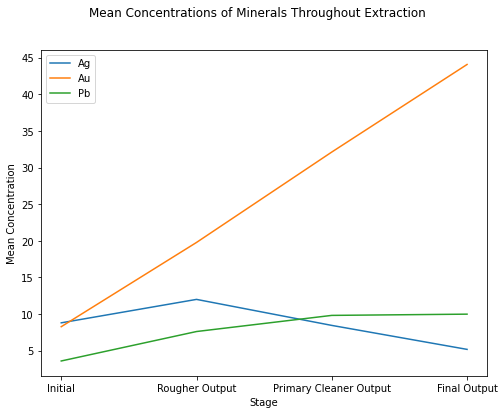

In [49]:
stages = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
minerals = ['ag','au','pb']
cols = []
for stage in stages:
    col = []
    for mineral in minerals:
        col.append(df_full[stage+mineral].mean())
    cols.append(col)
df_conc = pd.DataFrame(cols,columns=['Ag','Au','Pb'])

df_conc.plot(figsize=(8,6))
plt.suptitle("Mean Concentrations of Minerals Throughout Extraction")
plt.xticks([0,1,2,3], ['Initial','Rougher Output','Primary Cleaner Output','Final Output'],rotation='horizontal')
plt.ylabel('Mean Concentration')
plt.xlabel('Stage')
plt.show()

Throughout the process we can see the amount of gold linearly increase, the silver decreases slightly and the lead slightly increases.

#### 3.2 Feed Particle Size <a class="anchor" id="3_2"></a>

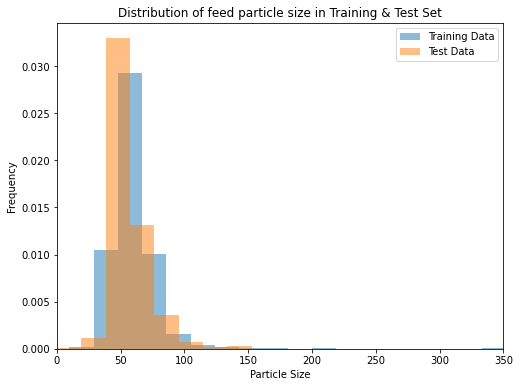

In [50]:
df_train['rougher.input.feed_size'].plot(kind='hist',density=True,bins=25,figsize=(8,6),xlim=[0,350],alpha=.5)
plt.suptitle("")
plt.title("Distribution of feed particle size in Training & Test Set")
df_test['rougher.input.feed_size'].plot(kind='hist',density=True,bins=25,alpha=0.5)
plt.xlabel("Particle Size")
plt.legend(['Training Data','Test Data'])
plt.show()

After normalization, the training and test share a similar distribution in terms of feed particle size.

#### 3.3 Total Concentrations <a class="anchor" id="3_3"></a>

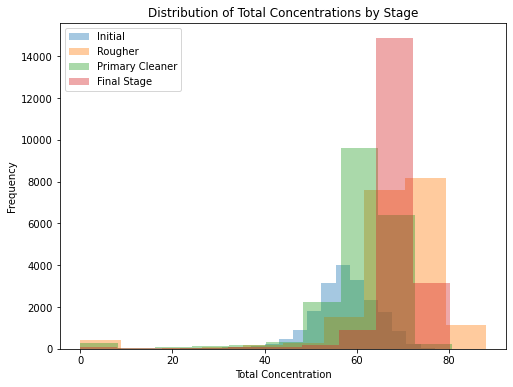

In [51]:
# function for adding columns of total concentration at each stage
def con_totals(df):
    df['input_total'] = pd.Series(
        df['rougher.input.feed_ag'] + 
        df['rougher.input.feed_pb'] + 
        df['rougher.input.feed_sol'] + 
        df['rougher.input.feed_au'] 
    )
    df['rougher_total'] = pd.Series(
        df['rougher.output.concentrate_ag'] + 
        df['rougher.output.concentrate_pb'] + 
        df['rougher.output.concentrate_sol'] + 
        df['rougher.output.concentrate_au'] 
    )
    df['primary_cleaner_total'] = pd.Series(
        df['primary_cleaner.output.concentrate_ag'] + 
        df['primary_cleaner.output.concentrate_pb'] + 
        df['primary_cleaner.output.concentrate_sol'] + 
        df['primary_cleaner.output.concentrate_au'] 
    )
    df['final_total'] = pd.Series(
        df['final.output.concentrate_ag'] + 
        df['final.output.concentrate_pb'] + 
        df['final.output.concentrate_sol'] + 
        df['final.output.concentrate_au'] 
    )
    return df

# function for plotting distribution of total concentration at each stage
def total_concentration_distribution(df):
    df['input_total'].plot(kind='hist',bins=25,figsize=(8,6),alpha=0.4)
    plt.title("Distribution of Total Concentrations by Stage")
    plt.xlabel("Total Concentration")
    df['rougher_total'].plot(kind='hist',alpha=0.4)
    df['primary_cleaner_total'].plot(kind='hist',alpha=0.4)
    df['final_total'].plot(kind='hist',alpha=0.4)
    plt.legend(['Initial','Rougher','Primary Cleaner','Final Stage'])
    plt.show()

df_full_totals = con_totals(df_full)
total_concentration_distribution(df_full_totals)

By the distribution we can see a clear left-skewed distribution with an anomoly in the lower total concentrations for non-initial stages. By removing the anomaly we will have a clearer distribution and better model. I will remove lower quantiles, but without slicing away too much of the data.

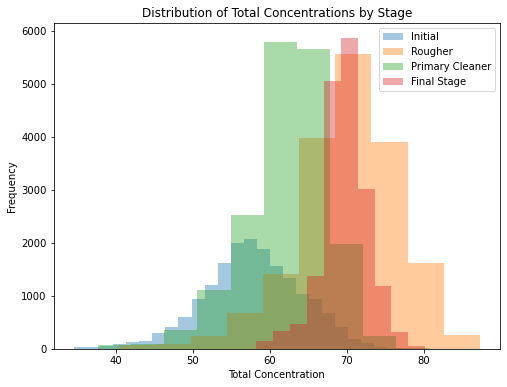

Percent of data remaining after removing anomoly = 91.67%


In [52]:
# remove lower outlier rows
low_quant = 0.03
min_initial = df_full_totals['input_total'].quantile(0.01)
min_rougher = df_full_totals['rougher_total'].quantile(low_quant)
min_primary = df_full_totals['primary_cleaner_total'].quantile(low_quant)
min_final = df_full_totals['final_total'].quantile(low_quant)
df_full_section = df_full_totals.query('@min_initial <= input_total and @min_rougher <= rougher_total and @min_primary <= primary_cleaner_total and @min_final <= final_total')

# display new distribution
total_concentration_distribution(df_full_section)
df_full_section = df_full_section.drop(['input_total','rougher_total','primary_cleaner_total','final_total'],axis=1)

# show how much data remains
data_kept = df_full_section.shape[0] / df_full_totals.shape[0] * 100
print("Percent of data remaining after removing anomoly = {:.2f}%".format(data_kept))

I have managed to remove the anomoly and kept more than 90% of the remaining data. I will remove these same rows from the train and testing data (by keeping existing dates of full) before making the model.

In [53]:
dates_no_anomaly = df_full_section['date']

# training data
df_train_section = df_train.query('date in @dates_no_anomaly')

# see how much data was removed
remain_train = df_train_section.shape[0] / df_train.shape[0] * 100
print("\nRemaining percent of training data = {:.2f}%".format(remain_train))


Remaining percent of training data = 91.44%


In [54]:
# test data
df_test_section = df_test.query('date in @dates_no_anomaly')

# see how much data was removed
remain_test = df_test_section.shape[0] / df_test.shape[0] * 100
print("Remaining percent of test data = {:.2f}%".format(remain_test))
print("Ratio of training to test data = {:.2f}:1".format(df_train_section.shape[0]/df_test_section.shape[0]))

Remaining percent of test data = 83.60%
Ratio of training to test data = 2.65:1


We have kept the vast majority of the data and removed the anomaly data. The ratio of training to test data is acceptable.

### 4. Model Training <a class="anchor" id="train"></a>

First I will split the train and test sets into features and targets. I will only keep features that are common between the training and test columns. Then I will define the sMAPE function as well as cross validation. Date column needs to be dropped as it isn't a valid feature.

In [55]:
df_train_section = df_train_section[df_test_section.columns]

missing_columns = set(list(df_train_section.columns))-set(list(df_test_section.columns))
print("Number of uncommmon columns between training and test data: {:}".format(len(missing_columns)))

try:
    df_train_section = df_train_section.drop(['date'],axis=1)
    df_test_section = df_test_section.drop(['date'],axis=1)
    print("Date column dropped")
except:
    print("Date column not dropped")

Number of uncommmon columns between training and test data: 0
Date column dropped


We have dropped features that may leak target.

In [56]:
# training data features & targets
features_train = df_train_section.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train_rough = df_train_section['rougher.output.recovery']
target_train_final = df_train_section['final.output.recovery']

# test data features & targets
features_test = df_test_section.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test_rough = df_test_section['rougher.output.recovery']
target_test_final = df_test_section['final.output.recovery']

# scale the features to minimize impact of dispersion
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

# function for calculating either part of the overall sMAPE
def smape_part(y,y_pred):
    N = len(y)
    y_pred = pd.Series(y_pred)
    sum_diffs = (abs(y-y_pred)/(abs(y_pred)+abs(y))*2).sum()
    smape_part = (1/N)*sum_diffs*100
    return smape_part

# function for showing smape (in parts and overall)
def display_smape(model_pred_rough,model_pred_final):
    sMAPE_rough = smape_part(target_test_rough,model_pred_rough)
    sMAPE_final = smape_part(target_test_final,model_pred_final)
    print("Rough sMAPE: {:.2f}".format(sMAPE_rough))
    print("Final sMAPE: {:.2f}".format(sMAPE_final))
    smape = (0.25*sMAPE_rough) + (0.75*sMAPE_final)
    print("sMAPE FINAL: {:.2f}".format(smape))
    
# creater scorer for cross-validation
smape_score = make_scorer(smape_part)

# function for cross evaluating model, to be used for tuning
def cross_val_smape(model,target_train):
    model.fit(features_train,target_train)
    scores = cross_val_score(model,features_train,target_train,scoring=smape_score, cv=3)
    return pd.Series(scores).mean()

#### 4.1 Baseline sMAPE <a class="anchor" id="4_1"></a>

First I will, using the median of the rough and final targets, check baseline sMAPE.

In [57]:
median_rough = pd.Series([target_train_rough.median()] * len(target_train_rough))
median_final = pd.Series([target_train_final.median()] * len(target_train_final))

# establish 'base' scores on both the rough and final median
print("- Baseline sMAPE -")
display_smape(median_rough,median_final)

- Baseline sMAPE -
Rough sMAPE: 5.76
Final sMAPE: 9.03
sMAPE FINAL: 8.21


#### 4.2 Linear Regression <a class="anchor" id="4_2"></a>

In [58]:
linear_rough = LinearRegression()
linear_rough.fit(features_train,target_train_rough)
linear_model_pred_rough = linear_rough.predict(features_test)

linear_final = LinearRegression()
linear_final.fit(features_train,target_train_final)
linear_model_pred_final = linear_final.predict(features_test)

print("Baseline sMAPE:")
display_smape(median_rough,median_final)
print("\nLinear Regression sMAPE:")
display_smape(linear_model_pred_rough,linear_model_pred_final)

Baseline sMAPE:
Rough sMAPE: 5.76
Final sMAPE: 9.03
sMAPE FINAL: 8.21

Linear Regression sMAPE:
Rough sMAPE: 6.46
Final sMAPE: 8.57
sMAPE FINAL: 8.04


The sMAPE in linear regresssion is higher in rougher but lower in final, so the overall sMAPE is lower than the baseline median score.

#### 4.3 Decision Tree Regressor <a class="anchor" id="4_3"></a>

In [59]:
state = np.random.RandomState(12345)

decision_rough = DecisionTreeRegressor(random_state=state)
decision_rough.fit(features_train,target_train_rough)
model_pred_rough = decision_rough.predict(features_test)

decision_final = DecisionTreeRegressor(random_state=state)
decision_final.fit(features_train,target_train_final)
model_pred_final = decision_final.predict(features_test)

print("Baseline sMAPE:")
display_smape(median_rough,median_final)
print("\nDecision Tree sMAPE:")
display_smape(model_pred_rough,model_pred_final)

Baseline sMAPE:
Rough sMAPE: 5.76
Final sMAPE: 9.03
sMAPE FINAL: 8.21

Decision Tree sMAPE:
Rough sMAPE: 6.96
Final sMAPE: 11.67
sMAPE FINAL: 10.49


The sMAPE for decision tree is worse than the baseline median score.

#### 4.4 Random Forest Regressor <a class="anchor" id="4_4"></a>

In [60]:
forest_rough = RandomForestRegressor(random_state=state)
forest_rough.fit(features_train,target_train_rough)
model_pred_rough = forest_rough.predict(features_test)

forest_final = RandomForestRegressor(random_state=state)
forest_final.fit(features_train,target_train_final)
model_pred_final = forest_final.predict(features_test)

print("Baseline sMAPE:")
display_smape(median_rough,median_final)
print("\nRandom Forest sMAPE:")
display_smape(model_pred_rough,model_pred_final)

Baseline sMAPE:
Rough sMAPE: 5.76
Final sMAPE: 9.03
sMAPE FINAL: 8.21

Random Forest sMAPE:
Rough sMAPE: 5.34
Final sMAPE: 8.41
sMAPE FINAL: 7.64


The random forest regression has the best (lowest) sMAPE of all the model but takes far too long to train, tuning is impractical. Instead I will tune the decision tree model and use these parameters (as it shares the parameters with Random Forest) to see if it can achieve a better sMAPE/score.

### 5 Parameter Hyperuning <a class="anchor" id="pht"></a>

#### 5.1 Rough Model <a class="anchor" id="5_1"></a>

First let's look at the default Random Forest's cross-validation scores for the rough model.

In [61]:
score_rough = cross_val_smape(forest_rough,target_train_rough)
print("Default Random Forest Rough Model Cross-val: {:.2f}".format(score_rough))

Default Random Forest Rough Model Cross-val: 2.0207123471272523


We want to maximize the score to better the 2.0 score of the random forest cross-validation.

In [71]:
best_depth = 0
best_split = 0
best_leaf = 0
best_nodes = 0
best_score = 0

# tune model for rough sMAPE
for i in range(16,27,2):
    for j in range(2,9):
        for k in range(1,9):
            for l in range(2,9,2):
                decision = DecisionTreeRegressor(random_state=state, max_depth=i, min_samples_split=j, min_samples_leaf=k, max_leaf_nodes=l)
                score = cross_val_smape(decision,target_train_rough)
                print("max_depth: {:.0f}, min_samples_split: {:.0f}, min_samples_leaf: {:.0f}, max_leaf_nodes:{:.0f}, Score:{:.2f}".format(i,j,k,l,score))
                if score > best_score:
                    best_score = score
                    best_depth = i
                    best_split = j
                    best_leaf = k
                    best_nodes = l

max_depth: 16, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes:2, Score:2.62
max_depth: 16, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes:4, Score:2.42
max_depth: 16, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes:6, Score:2.36
max_depth: 16, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes:8, Score:2.30
max_depth: 16, min_samples_split: 2, min_samples_leaf: 2, max_leaf_nodes:2, Score:2.62
max_depth: 16, min_samples_split: 2, min_samples_leaf: 2, max_leaf_nodes:4, Score:2.42
max_depth: 16, min_samples_split: 2, min_samples_leaf: 2, max_leaf_nodes:6, Score:2.36
max_depth: 16, min_samples_split: 2, min_samples_leaf: 2, max_leaf_nodes:8, Score:2.30
max_depth: 16, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes:2, Score:2.62
max_depth: 16, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes:4, Score:2.42
max_depth: 16, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes:6, Score:2.36
max_depth: 16, min_samples_split: 2, min_sa

In [72]:
print("The highest cross-validation score for rough sMAPE is {:.2f} with parameters: \n".format(best_score))
print("max_depth: {:.0f}".format(best_depth))
print("min_samples_split: {:.0f}".format(best_split))
print("min_samples_leaf: {:.0f}".format(best_leaf))
print("max_leaf_nodes: {:.0f}".format(best_nodes))

The highest cross-validation score for rough sMAPE is 2.62 with parameters: 

max_depth: 18
min_samples_split: 2
min_samples_leaf: 7
max_leaf_nodes: 2


#### 5.2 Final Model <a class="anchor" id="5_2"></a>

In [73]:
score_final = cross_val_smape(forest_final,target_train_final)
print("Default Random Forest Final Model Cross-val: {:.2f}".format(score_final))

Default Random Forest Final Model Cross-val: 2.97


We want to achieve a higher score than the 2.97 from the default Random Forest cross-validation.

In [74]:
best_depth = 0
best_split = 0
best_leaf = 0
best_nodes = 0
best_score = 0

# tune model for final sMAPE
for i in range(15,26):
    for j in range(2,11,2):
        for k in range(1,11,2):
            for l in range(2,9,2):
                decision = DecisionTreeRegressor(random_state=state, max_depth=i, min_samples_split=j, min_samples_leaf=k, max_leaf_nodes=l)
                score = cross_val_smape(decision,target_train_final)
                print("max_depth: {:.0f}, min_samples_split: {:.0f}, min_samples_leaf: {:.0f}, max_leaf_nodes={:.0f}, Score:{:.2f}".format(i,j,k,l,score))
                if score > best_score:
                    best_score = score
                    best_depth = i
                    best_split = j
                    best_leaf = k
                    best_nodes = l

max_depth: 15, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes=2, Score:2.62
max_depth: 15, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes=4, Score:3.07
max_depth: 15, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes=6, Score:3.20
max_depth: 15, min_samples_split: 2, min_samples_leaf: 1, max_leaf_nodes=8, Score:3.11
max_depth: 15, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes=2, Score:2.62
max_depth: 15, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes=4, Score:3.07
max_depth: 15, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes=6, Score:3.20
max_depth: 15, min_samples_split: 2, min_samples_leaf: 3, max_leaf_nodes=8, Score:3.11
max_depth: 15, min_samples_split: 2, min_samples_leaf: 5, max_leaf_nodes=2, Score:2.62
max_depth: 15, min_samples_split: 2, min_samples_leaf: 5, max_leaf_nodes=4, Score:3.07
max_depth: 15, min_samples_split: 2, min_samples_leaf: 5, max_leaf_nodes=6, Score:3.20
max_depth: 15, min_samples_split: 2, min_sa

In [75]:
print("The highest cross-validation score for final sMAPE is {:.2f} with parameters: \n".format(best_score))
print("max_depth: {:.0f}".format(best_depth))
print("min_samples_split: {:.0f}".format(best_split))
print("min_samples_leaf: {:.0f}".format(best_leaf))
print("max_leaf_nodes: {:.0f}".format(best_nodes))

The highest cross-validation score for final sMAPE is 3.20 with parameters: 

max_depth: 23
min_samples_split: 4
min_samples_leaf: 7
max_leaf_nodes: 6


#### 5.3 Tuned Model <a class="anchor" id="5_3"></a>

Now I will compare the tuned Random Forest model against the default Random Forest and baseline.

In [80]:
# using tuned parameters
# rough model
forest_rough_tuned = RandomForestRegressor(random_state=state,max_depth=18,min_samples_split=2,min_samples_leaf=7,max_leaf_nodes=2)
forest_rough_tuned.fit(features_train,target_train_rough)
model_pred_rough_tuned = forest_rough_tuned.predict(features_test)

# final model
forest_final_tuned = RandomForestRegressor(random_state=state,max_depth=23,min_samples_split=4,min_samples_leaf=7,max_leaf_nodes=6)
forest_final_tuned.fit(features_train,target_train_final)
model_pred_final_tuned = forest_final_tuned.predict(features_test)

print("---- Tuned Random Forest Model -----")
display_smape(model_pred_rough_tuned,model_pred_final_tuned)

print("\n------ Default Random Forest Model -----")
display_smape(model_pred_rough,model_pred_final)

print("\n-------- Baseline ----------")
display_smape(median_rough,median_final)

---- Tuned Random Forest Model -----
Rough sMAPE: 5.13
Final sMAPE: 8.21
sMAPE FINAL: 7.44

------ Default Random Forest Model -----
Rough sMAPE: 5.34
Final sMAPE: 8.41
sMAPE FINAL: 7.64

-------- Baseline ----------
Rough sMAPE: 5.76
Final sMAPE: 9.03
sMAPE FINAL: 8.21


## Conclusion <a class="anchor" id="end"></a>

Tuning the decision tree improved the model's cross validation score which translated also to a lower overall sMAPE using the same parameters with the random forest model. It looks like the Random Forest regression was best suited model for the problem. The Random Forest model had better scores in final sMAPE which had a greater impact on the overall sMAPE. While the default random forest regression had a lower sMAPE than the tuned and dummy model, we need to find further ways to improve this model.